# 1. 长短期记忆网络LSTM

注：为什么最后$H_t=O_t \odot tanh(C_t)$中还要加一个tanh呢？是因为在$C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C_{t-1}}$中虽然$\tilde{C_{t-1}}$是在[-1,1]之间，但并不能保证$C_t$的范围、它可能会比较大；所以这里还要再做一次tanh，将其值缩小至[-1,1]之间。

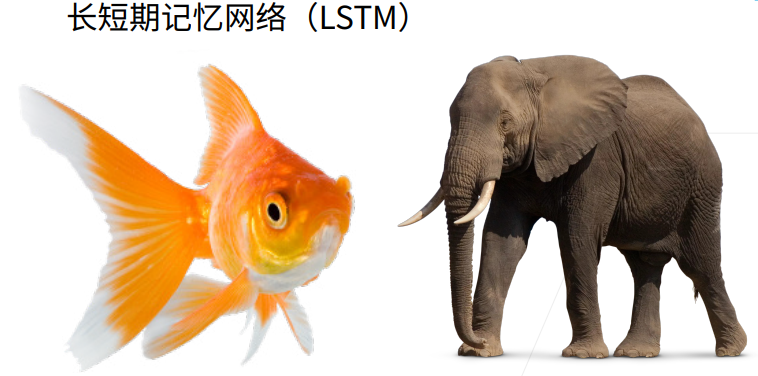

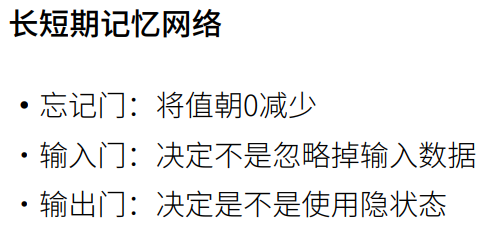

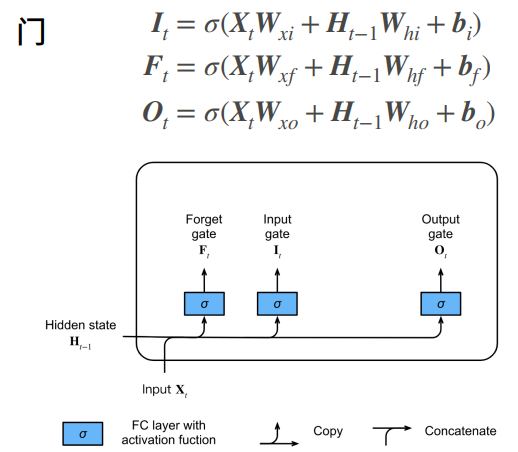

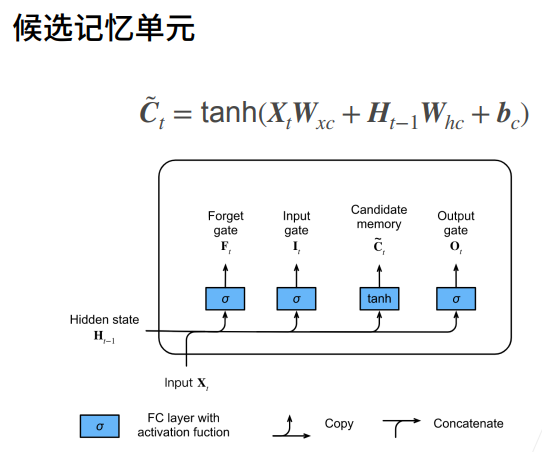

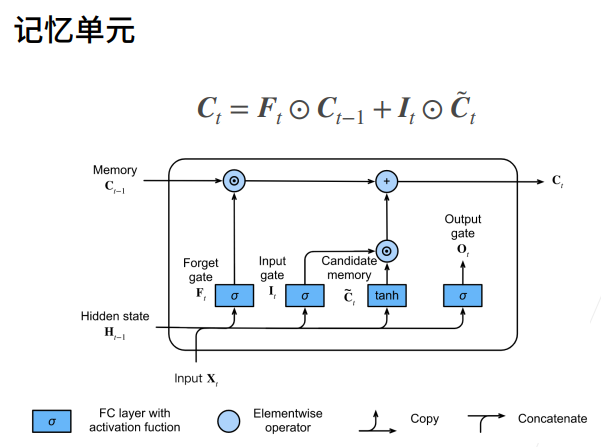

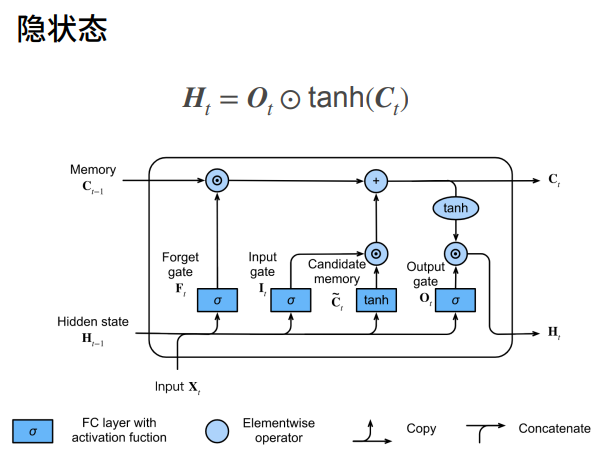

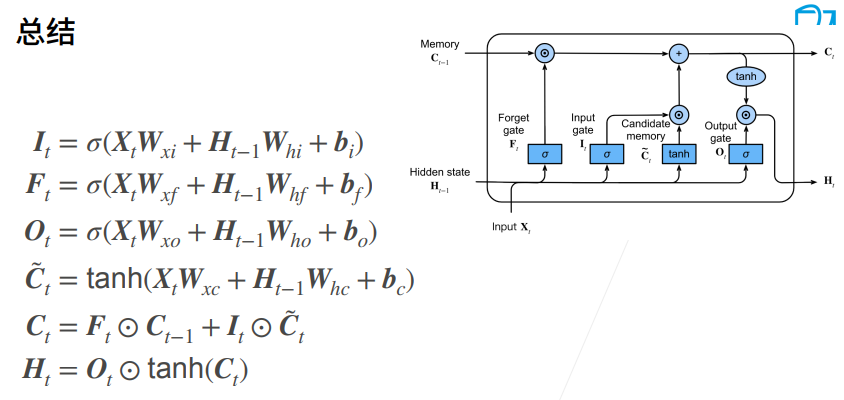

# 2. 长短期记忆网络LSTM

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xi, W_hi, b_i = three()
    W_xf, W_hf, b_f = three()
    W_xo, W_ho, b_o = three()
    
    W_xc, W_hc, b_c = three()
    
    # 输出层的参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q  = torch.zeros(num_outputs, device=device)
    
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]  # 共12+2=14个参数
    for param in params:
        param.requires_grad_(True)
    return params

In [3]:
# 初始化函数
# LSTM中需要分别对隐藏状态H和记忆单元C，两个参数均做初始化
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [4]:
# 实际模型
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        
        C = F * C + I * C_tilda
        
        H = O * torch.tanh(C)
        
        Y = (H @ W_hq) + b_q
        
        outputs.append(Y)
    
    return torch.cat(outputs, dim=0), (H, C)

perplexity 1.4, 17213.2 tokens/sec on cuda:0
time travelleryou cannes why hark gongan we canrersully right an
traveller the germon timess lonegaboug the fourth dimension


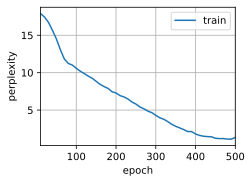

In [5]:
# 训练
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)       
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 335334.7 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


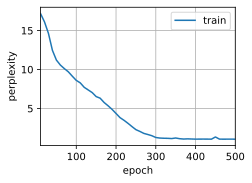

In [6]:
# 简洁实现
num_inputs = vocab_size
# 使用nn.LSTM来构建LSTM模型
lstm_layer = nn.LSTM(num_inputs, num_hiddens)

model = d2l.RNNModel(lstm_layer, len(vocab))
mode = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)